In [1]:

import os, random, time, math
from typing import Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ----------------------
# 1) 可重复性 & 设备
# ----------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(False)  # CPU 下保持高性能

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


In [ ]:
# ----------------------
# MNIST数据加载与预处理 mnist data loading and preprocessing
# ----------------------
data_root = "./data"
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),                       # 转为张量 [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # MNIST 均值/方差归一化
])

# 下载/加载训练与测试集
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)



# 从训练集中再划分出一部分作为验证集
val_ratio = 0.1
val_size  = int(len(train_full) * val_ratio)
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# DataLoader（CPU 环境的 num_workers 设为 2 更稳妥；若服务器限制，可改为 0）
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=False)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Train: 54000, Val: 6000, Test: 10000


In [ ]:
# CIFAR 数据加载与预处理 cifar data loading and preprocessing
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                         std=(0.2470, 0.2435, 0.2616))
])

cifar_train_full = datasets.CIFAR10(root=data_root, train=True, download=True, transform=cifar_transform)
cifar_test_ds    = datasets.CIFAR10(root=data_root, train=False, download=True, transform=cifar_transform)

val_ratio = 0.1
cifar_val_size = int(len(cifar_train_full) * val_ratio)
cifar_train_size = len(cifar_train_full) - cifar_val_size
cifar_train_ds, cifar_val_ds = random_split(
    cifar_train_full, [cifar_train_size, cifar_val_size],
    generator=torch.Generator().manual_seed(42)
)

cifar_train_loader = DataLoader(cifar_train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=False)
cifar_val_loader   = DataLoader(cifar_val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=False)
cifar_test_loader  = DataLoader(cifar_test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=False)

print(f"CIFAR10 -> Train: {len(cifar_train_ds)}, val: {len(cifar_val_ds)}, Test: {len(cifar_test_ds)}")

CIFAR10 -> Train: 45000, val: 5000, Test: 10000


In [4]:

# ----------------------
# 模型定义： T-MLP
# ----------------------
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dims=(256, 128), dropout=0.2):
        super().__init__()
        layers = []
        last = input_dim
        for h in hidden_dims:
            layers += [nn.Linear(last, h), nn.ReLU(), nn.Dropout(dropout)]
            last = h
        layers += [nn.Linear(last, num_classes)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        return self.net(x)



In [5]:
model_mnist = MLP(
    input_dim = 28*28,
    num_classes = 10
).to(device)

print(model_mnist)

# 参数量统计
total_params = sum(p.numel() for p in model_mnist.parameters())
trainable_params = sum(p.numel() for p in model_mnist.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total parameters: 235,146
Trainable parameters: 235,146


In [6]:

# ----------------------
# MNIST训练配置
# ----------------------
epochs = 10 #可按需调整到 15-20
criterion = nn.CrossEntropyLoss()

#适度权重衰减，让收敛更稳
optimizer = optim.Adam(model_mnist.parameters(), lr=1e-3, weight_decay=1e-4)

#Plateau 调度器在验证损失不再明显改善时降学习率
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-4,
    threshold_mode='rel',
    min_lr=1e-5
)
# 早停配置
early_stop_patience = 5 #稍微耐心一点
best_val_loss = float("inf")
patience_count = 0
ckpt_path = "./mnist_mlp_best.pt"


Epoch 01/10 | Time: 6.2s |Train Loss: 0.3357 Acc: 0.8988 | Val Loss: 0.1512 Acc: 0.9528 | LR: 1.0e-03
Epoch 02/10 | Time: 4.7s |Train Loss: 0.1419 Acc: 0.9570 | Val Loss: 0.1173 Acc: 0.9658 | LR: 1.0e-03
Epoch 03/10 | Time: 5.0s |Train Loss: 0.1071 Acc: 0.9670 | Val Loss: 0.1038 Acc: 0.9685 | LR: 1.0e-03
Epoch 04/10 | Time: 4.5s |Train Loss: 0.0876 Acc: 0.9725 | Val Loss: 0.0857 Acc: 0.9750 | LR: 1.0e-03
Epoch 05/10 | Time: 4.6s |Train Loss: 0.0775 Acc: 0.9753 | Val Loss: 0.0819 Acc: 0.9743 | LR: 1.0e-03
Epoch 06/10 | Time: 4.6s |Train Loss: 0.0644 Acc: 0.9800 | Val Loss: 0.0702 Acc: 0.9767 | LR: 1.0e-03
Epoch 07/10 | Time: 4.5s |Train Loss: 0.0592 Acc: 0.9809 | Val Loss: 0.0798 Acc: 0.9753 | LR: 1.0e-03
Epoch 08/10 | Time: 4.6s |Train Loss: 0.0517 Acc: 0.9832 | Val Loss: 0.0751 Acc: 0.9768 | LR: 1.0e-03
Epoch 09/10 | Time: 4.6s |Train Loss: 0.0512 Acc: 0.9831 | Val Loss: 0.0751 Acc: 0.9772 | LR: 5.0e-04
Epoch 10/10 | Time: 4.9s |Train Loss: 0.0325 Acc: 0.9893 | Val Loss: 0.0668 Acc: 0

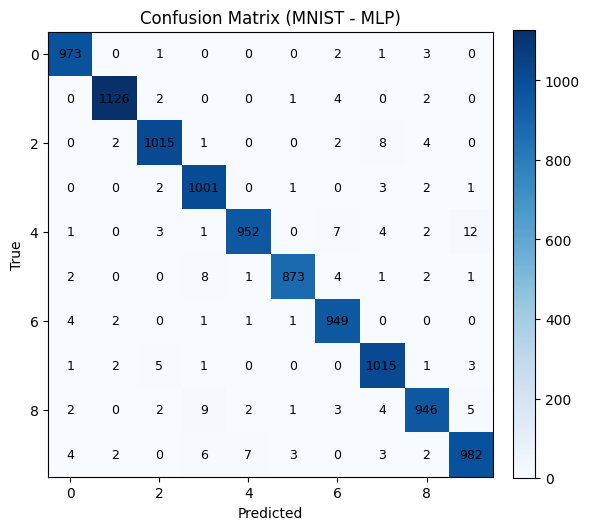

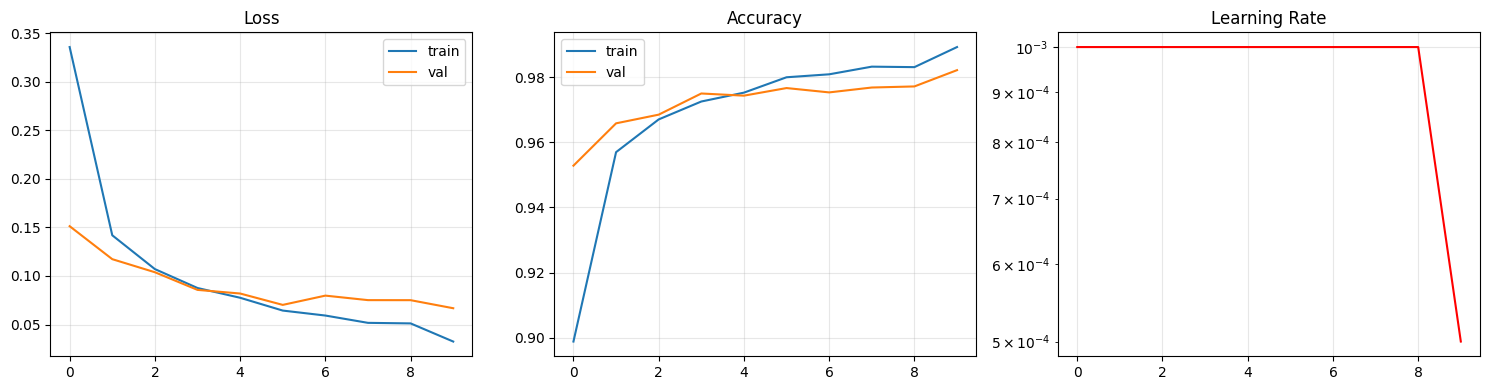

In [7]:

# ----------------------
# 5) MNIST训练与验证循环
# ----------------------
def run_one_epoch(loader, train: bool) -> Tuple[float, float]:
    model_mnist.train() if train else model_mnist.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0


    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            outputs = model_mnist(images)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                #可选：梯度裁剪，避免偶发爆梯度
                #torch.nn.utils.clip_norm_(model.parameters(), 1.0)
                optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lrs": [], "time": []}
# 新增：用于记录每个 epoch的学习率
start = time.time()
for ep in range(1, epochs + 1):
    ep_start = time.time()

    tr_loss, tr_acc = run_one_epoch(train_loader, train=True)
    val_loss, val_acc = run_one_epoch(val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lrs"].append(optimizer.param_groups[0]["lr"])

    #根据验证损失调整学习率(Plateau)
    scheduler.step(val_loss)

    # 计算与记事本epoch 用时
    ep_time = time.time() - ep_start
    history["time"].append(ep_time)
 
    print(f"Epoch {ep:02d}/{epochs} | "
          f"Time: {ep_time:.1f}s |"
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")


    # 早停与保存最优
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        patience_count = 0
        torch.save({
            "model": model_mnist.state_dict(),
            "epoch": ep,
            "best_val_loss": best_val_loss,
            "optimizer": optimizer.state_dict(),
        }, ckpt_path)
    else:
        patience_count += 1
        if patience_count >= early_stop_patience:
            print(f"Early stopping triggered at epoch {ep}.")
            break
# ----------------------
# 6) 测试评估：准确率、报告、混淆矩阵
# ----------------------
# 加载最佳权重
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model_mnist.load_state_dict(state["model"])

model_mnist.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_mnist(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

mnist_test_acc = (all_labels == all_preds).mean()
print(f"Test Accuracy: {mnist_test_acc:.4f}")

# 分类报告
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (MNIST - MLP)")

# 标注数字
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

# ----------------------
# 7) 训练曲线可视化（可选）
# ----------------------
#损失函数曲线
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(history["train_loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].set_title("Loss"); axes[0].legend(); axes[0].grid(alpha=0.3)

#准确率曲线
axes[1].plot(history["train_acc"], label="train")
axes[1].plot(history["val_acc"], label="val")
axes[1].set_title("Accuracy"); axes[1].legend(); axes[1].grid(alpha=0.3)

#学习率曲线（对数坐标更直观）
axes[2].plot(history["lrs"],label="learning rate", color="red")
axes[2].set_title("Learning Rate")
axes[2].set_yscale("log")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()




In [8]:
model_cifar = MLP(
    input_dim = 32*32*3,
    num_classes = 10
).to(device)

print(model_cifar)

# 参数量统计
total_params = sum(p.numel() for p in model_cifar.parameters())
trainable_params = sum(p.numel() for p in model_cifar.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MLP(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total parameters: 820,874
Trainable parameters: 820,874


In [9]:

# ----------------------
# cifar训练配置
# ----------------------
epochs = 50 #可按需调整到 15-20
criterion = nn.CrossEntropyLoss()

#适度权重衰减，让收敛更稳
optimizer = optim.Adam(model_cifar.parameters(), lr=1e-3, weight_decay=1e-4)

#Plateau 调度器在验证损失不再明显改善时降学习率
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    threshold=1e-4,
    threshold_mode='rel',
    min_lr=1e-5
)
# 早停配置
early_stop_patience = 5 #稍微耐心一点
best_val_loss = float("inf")
patience_count = 0
ckpt_path = "./cifar10_mlp_best.pt"


Epoch 01/50 | Time: 4.4s |Train Loss: 1.7545 Acc: 0.3787 | Val Loss: 1.6025 Acc: 0.4368 | LR: 1.0e-03
Epoch 02/50 | Time: 5.1s |Train Loss: 1.5861 Acc: 0.4382 | Val Loss: 1.5139 Acc: 0.4726 | LR: 1.0e-03
Epoch 03/50 | Time: 5.1s |Train Loss: 1.5150 Acc: 0.4642 | Val Loss: 1.4666 Acc: 0.4808 | LR: 1.0e-03
Epoch 04/50 | Time: 5.1s |Train Loss: 1.4643 Acc: 0.4805 | Val Loss: 1.4546 Acc: 0.4852 | LR: 1.0e-03
Epoch 05/50 | Time: 4.5s |Train Loss: 1.4205 Acc: 0.4978 | Val Loss: 1.4178 Acc: 0.5060 | LR: 1.0e-03
Epoch 06/50 | Time: 4.5s |Train Loss: 1.3860 Acc: 0.5083 | Val Loss: 1.4091 Acc: 0.5046 | LR: 1.0e-03
Epoch 07/50 | Time: 4.5s |Train Loss: 1.3592 Acc: 0.5179 | Val Loss: 1.3973 Acc: 0.5178 | LR: 1.0e-03
Epoch 08/50 | Time: 4.7s |Train Loss: 1.3328 Acc: 0.5273 | Val Loss: 1.3793 Acc: 0.5132 | LR: 1.0e-03
Epoch 09/50 | Time: 4.5s |Train Loss: 1.3076 Acc: 0.5356 | Val Loss: 1.3602 Acc: 0.5286 | LR: 1.0e-03
Epoch 10/50 | Time: 4.4s |Train Loss: 1.2846 Acc: 0.5448 | Val Loss: 1.3648 Acc: 0

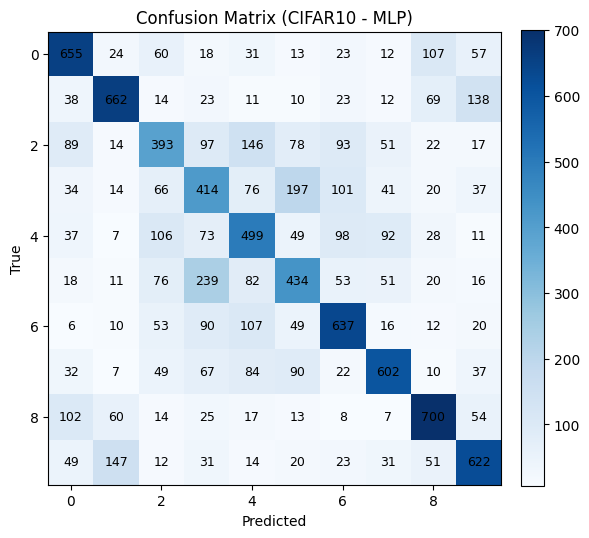

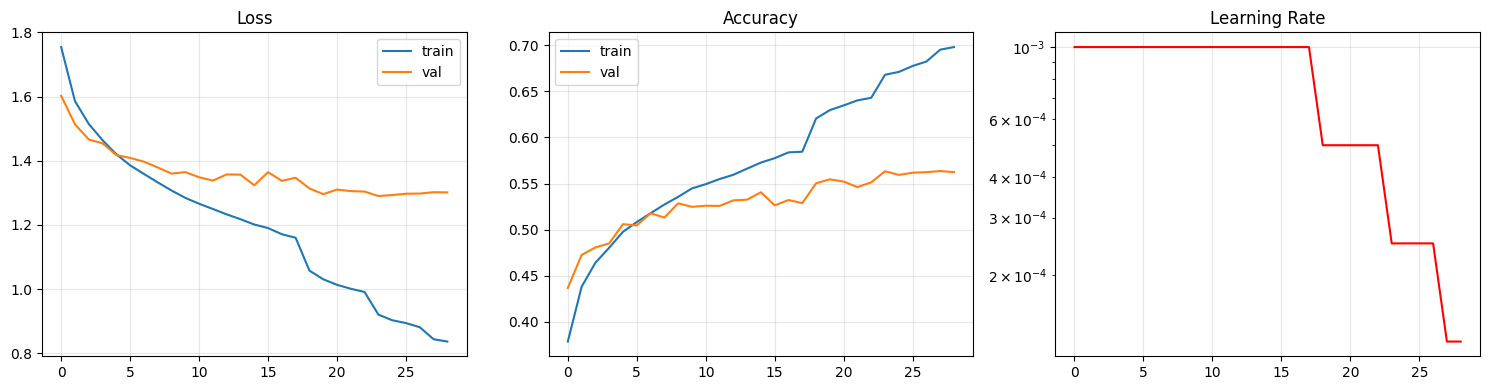

In [10]:

# ----------------------
# 5) cifar训练与验证循环
# ----------------------
def run_one_epoch(loader, train: bool) -> Tuple[float, float]:
    model_cifar.train() if train else model_cifar.eval()
    epoch_loss = 0.0
    correct = 0
    total = 0


    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(train):
            outputs = model_cifar(images)
            loss = criterion(outputs, labels)
            if train:
                loss.backward()
                #可选：梯度裁剪，避免偶发爆梯度
                #torch.nn.utils.clip_norm_(model_cifar.parameters(), 1.0)
                optimizer.step()

        epoch_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return epoch_loss / total, correct / total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lrs": [], "time": []}
# 新增：用于记录每个 epoch的学习率
start = time.time()
for ep in range(1, epochs + 1):
    ep_start = time.time()
    tr_loss, tr_acc = run_one_epoch(cifar_train_loader, train=True)
    val_loss, val_acc = run_one_epoch(cifar_val_loader, train=False)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lrs"].append(optimizer.param_groups[0]["lr"])

    #根据验证损失调整学习率(Plateau)
    scheduler.step(val_loss)

    # 计算与记事本epoch 用时
    ep_time = time.time() - ep_start
    history["time"].append(ep_time)
 
    print(f"Epoch {ep:02d}/{epochs} | "
          f"Time: {ep_time:.1f}s |"
          f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")


    # 早停与保存最优
    if val_loss < best_val_loss - 1e-5:
        best_val_loss = val_loss
        patience_count = 0
        torch.save({
            "model": model_cifar.state_dict(),
            "epoch": ep,
            "best_val_loss": best_val_loss,
            "optimizer": optimizer.state_dict(),
        }, ckpt_path)
    else:
        patience_count += 1
        if patience_count >= early_stop_patience:
            print(f"Early stopping triggered at epoch {ep}.")
            break
# ----------------------
# 6) 测试评估：准确率、报告、混淆矩阵
# ----------------------
# 加载最佳权重
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model_cifar.load_state_dict(state["model"])

model_cifar.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in cifar_test_loader:
        images = images.to(device)
        outputs = model_cifar(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

cifar_test_acc = (all_labels == all_preds).mean()
print(f"Test Accuracy: {cifar_test_acc:.4f}")

# 分类报告
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (CIFAR10 - MLP)")

# 标注数字
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()

# ----------------------
# 7) 训练曲线可视化（可选）
# ----------------------
#损失函数曲线
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].plot(history["train_loss"], label="train")
axes[0].plot(history["val_loss"], label="val")
axes[0].set_title("Loss"); axes[0].legend(); axes[0].grid(alpha=0.3)

#准确率曲线
axes[1].plot(history["train_acc"], label="train")
axes[1].plot(history["val_acc"], label="val")
axes[1].set_title("Accuracy"); axes[1].legend(); axes[1].grid(alpha=0.3)

#学习率曲线（对数坐标更直观）
axes[2].plot(history["lrs"],label="learning rate", color="red")
axes[2].set_title("Learning Rate")
axes[2].set_yscale("log")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()




In [11]:
%pip install prettytable


Note: you may need to restart the kernel to use updated packages.


In [12]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

mnist_params = count_params(model_mnist)           # 你原来的 MNIST MLP
cifar_params = count_params(model_cifar)     # 新的 CIFAR10 MLP

print(f"MNIST MLP params: total={mnist_params[0]:,}, trainable={mnist_params[1]:,}")
print(f"CIFAR10 MLP params: total={cifar_params[0]:,}, trainable={cifar_params[1]:,}")

from prettytable import PrettyTable
tbl = PrettyTable(["Model", "MNIST (acc, params)", "CIFAR10 (acc, params)"])
tbl.add_row(["MLP",
             f"{mnist_test_acc:.4f}, {mnist_params[0]:,}",
             f"{cifar_test_acc:.4f}, {cifar_params[0]:,}"])
print(tbl)

MNIST MLP params: total=235,146, trainable=235,146
CIFAR10 MLP params: total=820,874, trainable=820,874
+-------+---------------------+-----------------------+
| Model | MNIST (acc, params) | CIFAR10 (acc, params) |
+-------+---------------------+-----------------------+
|  MLP  |   0.9832, 235,146   |    0.5618, 820,874    |
+-------+---------------------+-----------------------+
